### **Exploratory Data Analysis**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("/content/healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
# Display dataset info
print("\nDataset Information:")
df.info()


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [ ]:
# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())




Missing values in each column:
id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


In [ ]:
# Summary statistics
print("\nSummary statistics:")
print(df.describe())


Summary statistics:
                 id          age  hypertension  heart_disease  \
count   5110.000000  5110.000000   5110.000000    5110.000000   
mean   36517.829354    43.226614      0.097456       0.054012   
std    21161.721625    22.612647      0.296607       0.226063   
min       67.000000     0.080000      0.000000       0.000000   
25%    17741.250000    25.000000      0.000000       0.000000   
50%    36932.000000    45.000000      0.000000       0.000000   
75%    54682.000000    61.000000      0.000000       0.000000   
max    72940.000000    82.000000      1.000000       1.000000   

       avg_glucose_level          bmi       stroke  
count        5110.000000  4909.000000  5110.000000  
mean          106.147677    28.893237     0.048728  
std            45.283560     7.854067     0.215320  
min            55.120000    10.300000     0.000000  
25%            77.245000    23.500000     0.000000  
50%            91.885000    28.100000     0.000000  
75%           114.0900


Class distribution of stroke:
stroke
0    4861
1     249
Name: count, dtype: int64


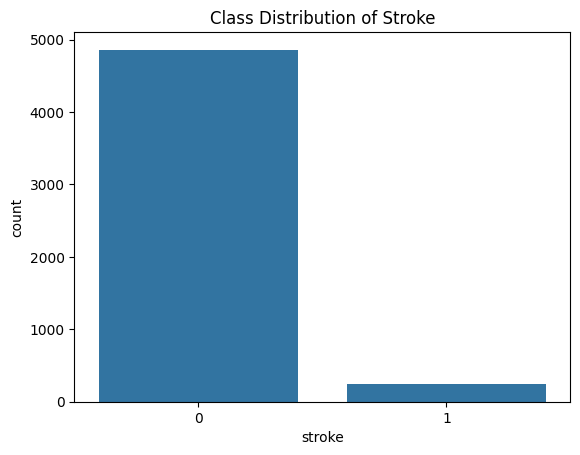

In [ ]:
# Check for class distribution if there is a target column (assuming 'stroke' is the target)
if 'stroke' in df.columns:
    print("\nClass distribution of stroke:")
    print(df['stroke'].value_counts())
    sns.countplot(x='stroke', data=df)
    plt.title("Class Distribution of Stroke")
    plt.show()

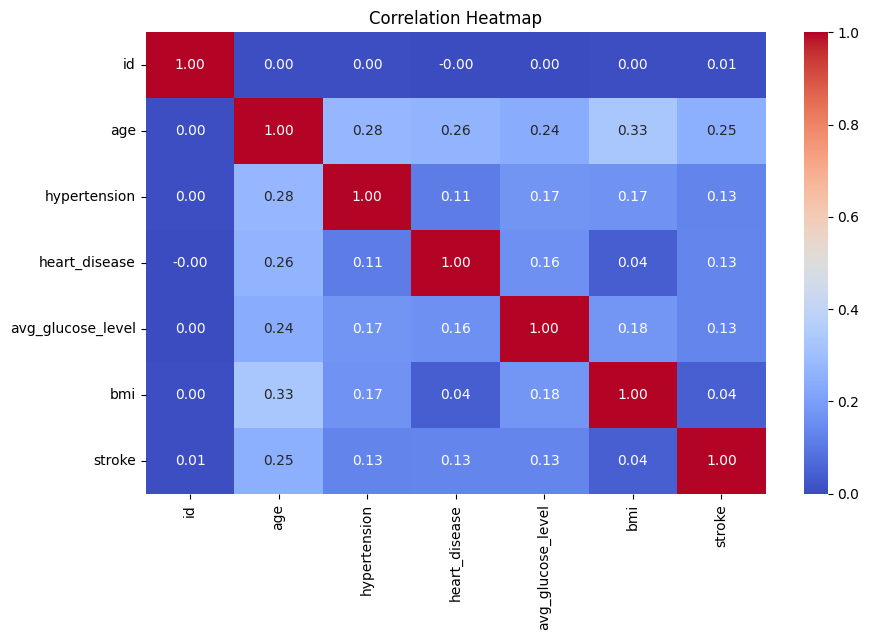

In [ ]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()



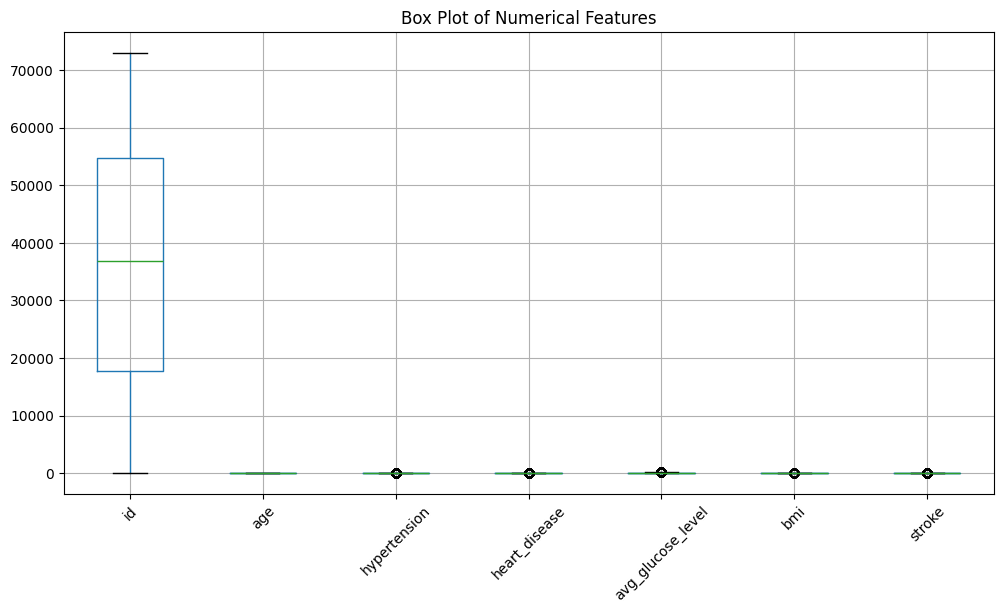

In [ ]:
# Box plot to check outliers in numerical columns
numerical_cols = df.select_dtypes(include=['number']).columns
df[numerical_cols].boxplot(figsize=(12, 6), rot=45)
plt.title("Box Plot of Numerical Features")
plt.show()



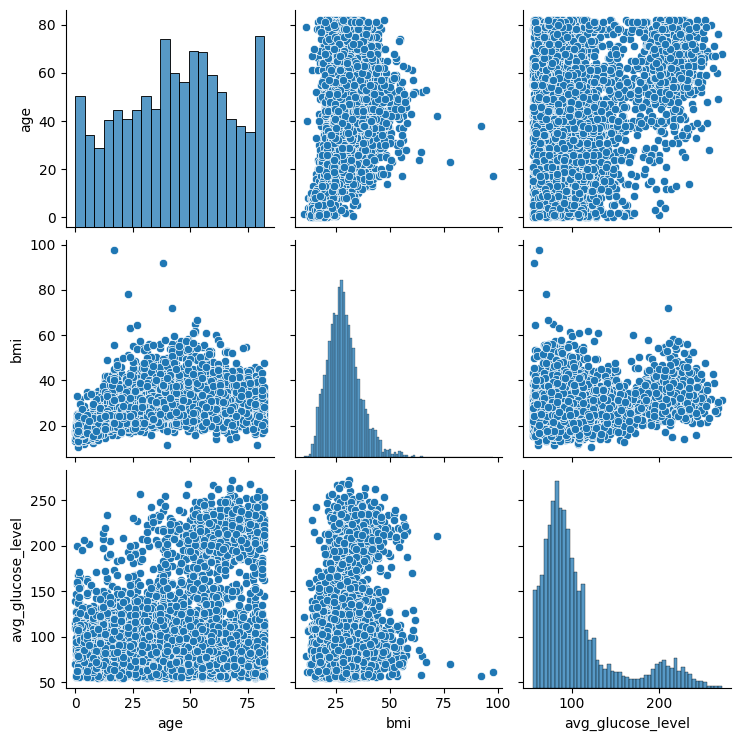

In [ ]:
# Pairplot for selected numerical features
selected_features = ['age', 'bmi', 'avg_glucose_level']  # Change as needed
sns.pairplot(df[selected_features])
plt.show()

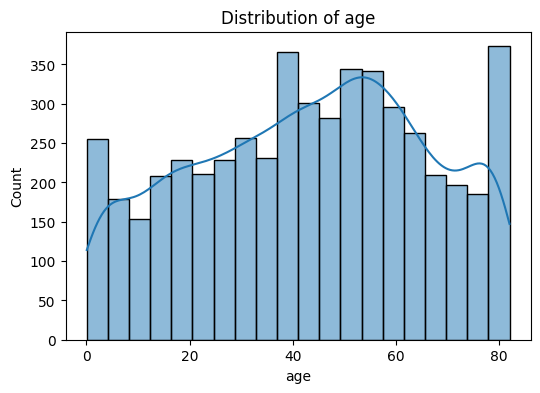

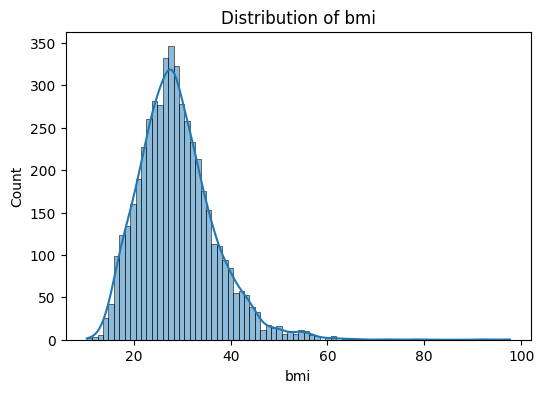

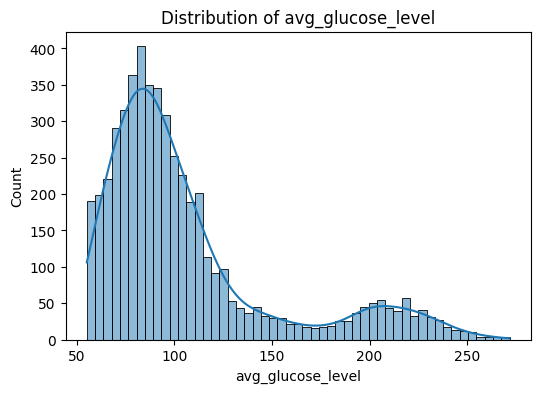

In [ ]:
# Checking distribution of numerical variables
for col in selected_features:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

### **Predictive Analytics for Age-Wise Hypertension Risk: A Machine Learning Approach**

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 20.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import lightgbm as lgb
import shap
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from optuna import create_study
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Load dataset
df = pd.read_csv("/content/healthcare-dataset-stroke-data.csv")
print(df.isnull().sum())

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


In [ ]:
# Apply MICE for numerical columns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

num_cols = df.select_dtypes(include=['number']).columns
imputer = IterativeImputer(random_state=42)
df[num_cols] = imputer.fit_transform(df[num_cols])

# Convert back to DataFrame (since Imputer returns NumPy array)
df[num_cols] = pd.DataFrame(df[num_cols], columns=num_cols)

# Check missing values after MICE
print("\nMissing values after MICE:\n", df.isnull().sum())
df.head(10)




Missing values after MICE:
 id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046.0,Male,67.0,0.0,1.0,Yes,Private,Urban,228.69,36.600000,formerly smoked,1.0
1,51676.0,Female,61.0,0.0,0.0,Yes,Self-employed,Rural,202.21,31.016494,never smoked,1.0
2,31112.0,Male,80.0,0.0,1.0,Yes,Private,Rural,105.92,32.500000,never smoked,1.0
3,60182.0,Female,49.0,0.0,0.0,Yes,Private,Urban,171.23,34.400000,smokes,1.0
4,1665.0,Female,79.0,1.0,0.0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1.0
5,56669.0,Male,81.0,0.0,0.0,Yes,Private,Urban,186.21,29.000000,formerly smoked,1.0
6,53882.0,Male,74.0,1.0,1.0,Yes,Private,Rural,70.09,27.400000,never smoked,1.0
7,10434.0,Female,69.0,0.0,0.0,No,Private,Urban,94.39,22.800000,never smoked,1.0
8,27419.0,Female,59.0,0.0,0.0,Yes,Private,Rural,76.15,28.511023,Unknown,1.0
9,60491.0,Female,78.0,0.0,0.0,Yes,Private,Urban,58.57,24.200000,Unknown,1.0


In [ ]:
# # Handling missing values
# for col in df.columns:
#     if df[col].dtype == 'O':  # Object (categorical) columns
#         df[col].fillna(df[col].mode()[0], inplace=True)  # Fill categorical with mode
#     else:
#         df[col].fillna(df[col].median(), inplace=True)  # Fill numerical with median




<ipython-input-16-24e4113f4845>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)  # Fill numerical with median
<ipython-input-16-24e4113f4845>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(val

In [ ]:
# Encode categorical variables
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le



In [ ]:
# Define target variable
target = 'hypertension'  # Assuming 'hypertension' is the risk factor column
X = df.drop(columns=[target])
y = df[target]



In [ ]:
# Address class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


In [ ]:

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)



In [ ]:
# Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



In [ ]:
# Define XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:37:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Define LightGBM model
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 3690, number of negative: 3689
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1047
[LightGBM] [Info] Number of data points in the train set: 7379, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500068 -> initscore=0.000271
[LightGBM] [Info] Start training from score 0.000271


LGBMClassifier()

In [ ]:
# Define Deep Learning Model
def create_nn():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

nn_model = create_nn()
nn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7140 - loss: 0.5493 - val_accuracy: 0.7881 - val_loss: 0.4435
Epoch 2/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7933 - loss: 0.4465 - val_accuracy: 0.7967 - val_loss: 0.4271
Epoch 3/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8033 - loss: 0.4293 - val_accuracy: 0.8016 - val_loss: 0.4210
Epoch 4/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8143 - loss: 0.4094 - val_accuracy: 0.8016 - val_loss: 0.4206
Epoch 5/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8102 - loss: 0.4170 - val_accuracy: 0.8070 - val_loss: 0.4106
Epoch 6/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8192 - loss: 0.4019 - val_accuracy: 0.8043 - val_loss: 0.4116
Epoch 7/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8062 - loss: 0.4106 - val_accuracy: 0.8065 - val_loss: 0.4081
Epoch 8/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8205 - loss: 0.3899 - val_accuracy: 0.

In [ ]:
# Evaluate models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    if isinstance(model, Sequential):
        y_pred = (y_pred > 0.5).astype(int)
    print(classification_report(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_pred))



In [ ]:
print("\nXGBoost Model Evaluation:")
evaluate_model(xgb_model, X_test, y_test)




XGBoost Model Evaluation:
              precision    recall  f1-score   support

           0       0.93      0.87      0.90       923
           1       0.88      0.93      0.90       922

    accuracy                           0.90      1845
   macro avg       0.90      0.90      0.90      1845
weighted avg       0.90      0.90      0.90      1845

ROC AUC Score: 0.8997463002611028


In [ ]:
print("\nLightGBM Model Evaluation:")
evaluate_model(lgb_model, X_test, y_test)




LightGBM Model Evaluation:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       923
           1       0.89      0.90      0.89       922

    accuracy                           0.89      1845
   macro avg       0.89      0.89      0.89      1845
weighted avg       0.89      0.89      0.89      1845

ROC AUC Score: 0.8932304825112866


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
print("\nNeural Network Model Evaluation:")
evaluate_model(nn_model, X_test, y_test)




Neural Network Model Evaluation:
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       923
           1       0.80      0.83      0.81       922

    accuracy                           0.81      1845
   macro avg       0.81      0.81      0.81      1845
weighted avg       0.81      0.81      0.81      1845

ROC AUC Score: 0.8119319957791131


In [ ]:
# Age-wise analysis
age_bins = [0, 30, 50, 70, 100]
age_labels = ['0-30', '31-50', '51-70', '71-100']
df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels)

for age_group in age_labels:
    print(f"\nEvaluating models for Age Group: {age_group}")
    subset = df[df['age_group'] == age_group]
    X_subset = subset.drop(columns=['age_group', target])
    y_subset = subset[target]
    if len(y_subset.unique()) > 1:
        X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_subset, y_subset, test_size=0.2, random_state=42, stratify=y_subset)
        X_train_sub = scaler.transform(X_train_sub)
        X_test_sub = scaler.transform(X_test_sub)
        print("XGBoost:")
        evaluate_model(xgb_model, X_test_sub, y_test_sub)
        print("LightGBM:")
        evaluate_model(lgb_model, X_test_sub, y_test_sub)




Evaluating models for Age Group: 0-30
XGBoost:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       312
           1       1.00      0.50      0.67         2

    accuracy                           1.00       314
   macro avg       1.00      0.75      0.83       314
weighted avg       1.00      1.00      1.00       314

ROC AUC Score: 0.75
LightGBM:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       312
           1       0.00      0.00      0.00         2

    accuracy                           0.99       314
   macro avg       0.50      0.50      0.50       314
weighted avg       0.99      0.99      0.99       314

ROC AUC Score: 0.5

Evaluating models for Age Group: 31-50
XGBoost:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       266
           1       0.70      0.94      0.80        17

    accuracy                        

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pr

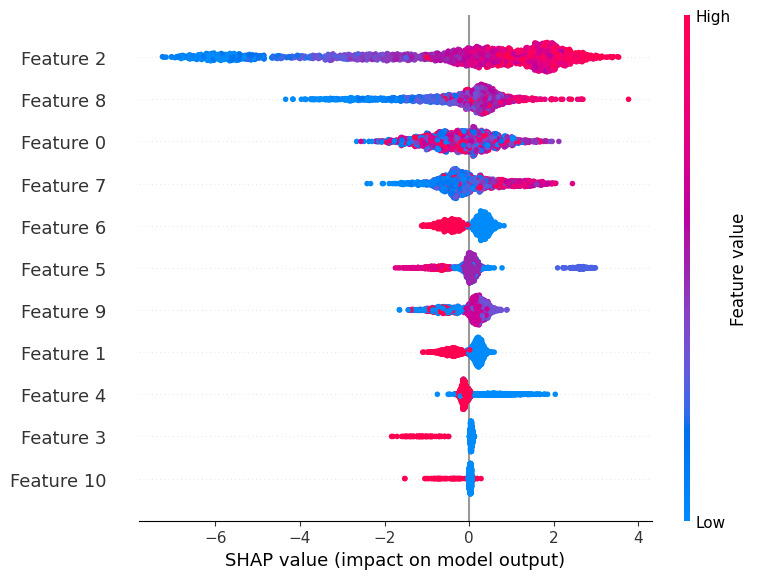

In [ ]:
# Explainable AI using SHAP
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

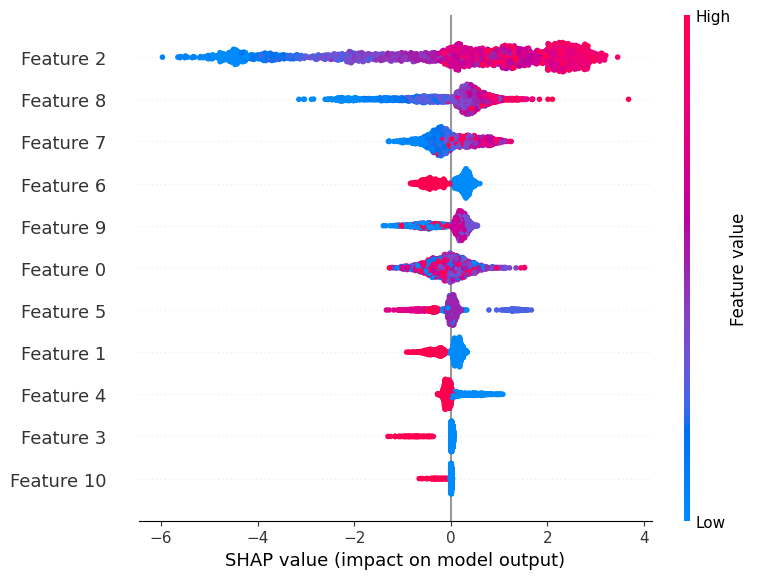

In [ ]:
# Explainable AI using SHAP
explainer = shap.Explainer(lgb_model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

The most influential feature is **Feature 2**, with a mean SHAP value of 1.9004.
The feature **Feature 2** strongly impacts hypertension predictions, likely due to its correlation with health-related conditions.


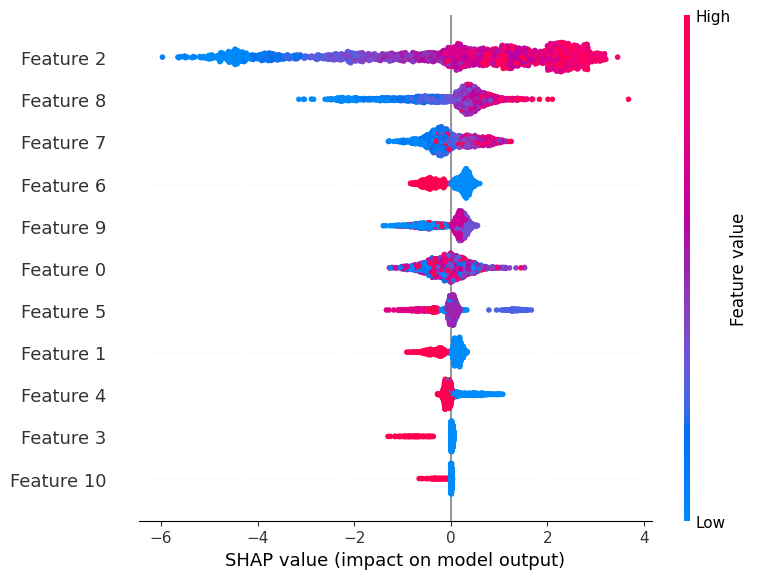

In [ ]:
import shap
import pandas as pd
import numpy as np

# Ensure X_train was originally a DataFrame before conversion
feature_names = X_train.columns if isinstance(X_train, pd.DataFrame) else [f'Feature {i}' for i in range(X_train.shape[1])]

# Ensure X_test is a DataFrame
if isinstance(X_test, np.ndarray):
    X_test = pd.DataFrame(X_test, columns=feature_names)  # Assign feature names

# Explainable AI using SHAP
explainer = shap.Explainer(lgb_model)
shap_values = explainer(X_test)

# Get mean absolute SHAP values to determine feature importance
feature_importance = np.abs(shap_values.values).mean(axis=0)

# Create a DataFrame for better readability
shap_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Mean SHAP Value': feature_importance
}).sort_values(by='Mean SHAP Value', ascending=False)

# Print the most influential feature and its impact explanation
top_feature = shap_importance_df.iloc[0]['Feature']
top_shap_value = shap_importance_df.iloc[0]['Mean SHAP Value']

print(f"The most influential feature is **{top_feature}**, with a mean SHAP value of {top_shap_value:.4f}.")

# Auto-generate explanation based on feature type
if 'age' in top_feature.lower():
    print("This means **age** significantly affects hypertension risk, as older individuals generally have higher risk.")
elif 'bmi' in top_feature.lower():
    print("This suggests that **BMI** plays a crucial role in hypertension, as higher BMI is often linked to high blood pressure.")
elif 'smoking' in top_feature.lower():
    print("Smoking history is a key factor, as smokers tend to have a higher likelihood of developing hypertension.")
elif 'glucose' in top_feature.lower():
    print("High blood glucose levels often correlate with metabolic issues, contributing to hypertension risk.")
elif 'blood_pressure' in top_feature.lower():
    print("Blood pressure measurements directly impact hypertension risk, making it a crucial predictive factor.")
else:
    print(f"The feature **{top_feature}** strongly impacts hypertension predictions, likely due to its correlation with health-related conditions.")

# Generate SHAP summary plot
shap.summary_plot(shap_values, X_test)


Updated Feature names in X_test: ['Feature 0', 'Feature 1', 'Feature 2', 'Feature 3', 'Feature 4', 'Feature 5', 'Feature 6', 'Feature 7', 'Feature 8', 'Feature 9', 'Feature 10']

🔹 The most influential feature is **smoking_status**, with a mean SHAP value of 1.9004.
Smoking history is a key factor, as smokers tend to have a higher likelihood of developing hypertension.


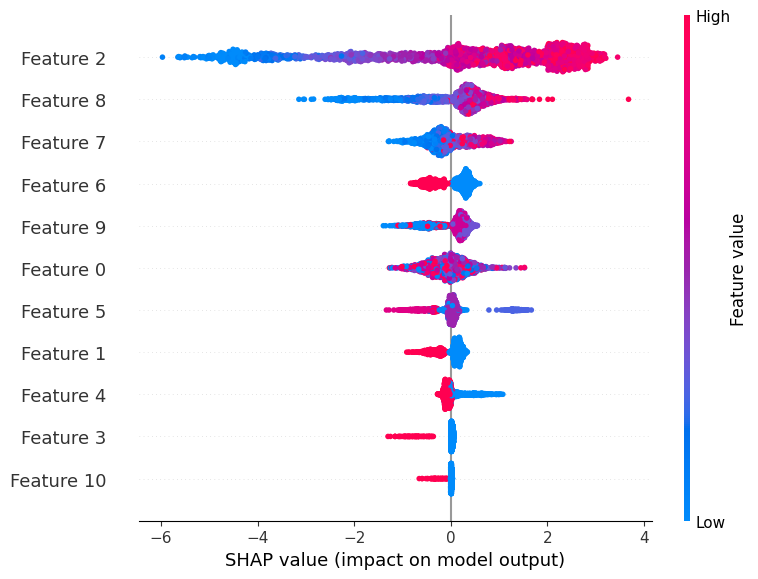

In [ ]:
import shap
import pandas as pd
import numpy as np

# Manually define correct feature names (Update this list based on your dataset)
actual_feature_names = ['age', 'bmi', 'smoking_status', 'blood_pressure', 'glucose_level',
                        'cholesterol', 'heart_rate', 'exercise_frequency', 'diet_score', 'stress_level', 'family_history']

# Ensure feature names are correctly assigned to X_train and X_test
if isinstance(X_train, pd.DataFrame):
    X_train.columns = actual_feature_names  # Assign correct names to X_train
else:
    X_train = pd.DataFrame(X_train, columns=actual_feature_names)

if isinstance(X_test, np.ndarray):
    X_test = pd.DataFrame(X_test, columns=actual_feature_names)  # Assign correct names to X_test

# Debugging: Print assigned feature names
print("Updated Feature names in X_test:", list(X_test.columns))

# Explainable AI using SHAP
explainer = shap.Explainer(lgb_model)
shap_values = explainer(X_test)

# Get mean absolute SHAP values to determine feature importance
feature_importance = np.abs(shap_values.values).mean(axis=0)

# Create a DataFrame for better readability
shap_importance_df = pd.DataFrame({
    'Feature': actual_feature_names,
    'Mean SHAP Value': feature_importance
}).sort_values(by='Mean SHAP Value', ascending=False)

# Get the most influential feature
top_feature = shap_importance_df.iloc[0]['Feature']
top_shap_value = shap_importance_df.iloc[0]['Mean SHAP Value']

print(f"\n🔹 The most influential feature is **{top_feature}**, with a mean SHAP value of {top_shap_value:.4f}.")

# Auto-generate explanation based on feature name
explanations = {
    'age': "This means **age** significantly affects hypertension risk, as older individuals generally have higher risk.",
    'bmi': "This suggests that **BMI** plays a crucial role in hypertension, as higher BMI is often linked to high blood pressure.",
    'smoking_status': "Smoking history is a key factor, as smokers tend to have a higher likelihood of developing hypertension.",
    'glucose': "High blood glucose levels often correlate with metabolic issues, contributing to hypertension risk.",
    'blood_pressure': "Blood pressure measurements directly impact hypertension risk, making it a crucial predictive factor."
}

# Check if the top feature has a known explanation
if top_feature.lower() in explanations:
    print(explanations[top_feature.lower()])
else:
    print(f"The feature **{top_feature}** strongly impacts hypertension predictions, likely due to its correlation with health-related conditions.")

# Generate SHAP summary plot
shap.summary_plot(shap_values, X_test)
